In [41]:
import numpy as np 
import pandas as pd 
import joblib
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier, plot_importance
import shap
import lime
import lime.lime_tabular

In [42]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [43]:
categorical_columns = df.select_dtypes(include=['object', 'category'])
for feature in categorical_columns:
    print(f"Column: {feature} -> {df[feature].unique()}")
    print(f"Unique Number: {df[feature].nunique()}")
    print(f"{df[feature].value_counts()} \n")

Column: customerID -> ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique Number: 7043
customerID
3186-AJIEK    1
7590-VHVEG    1
5575-GNVDE    1
4501-VCPFK    1
6075-SLNIL    1
             ..
1452-KIOVK    1
6713-OKOMC    1
7892-POOKP    1
6388-TABGU    1
9763-GRSKD    1
Name: count, Length: 7043, dtype: int64 

Column: gender -> ['Female' 'Male']
Unique Number: 2
gender
Male      3555
Female    3488
Name: count, dtype: int64 

Column: Partner -> ['Yes' 'No']
Unique Number: 2
Partner
No     3641
Yes    3402
Name: count, dtype: int64 

Column: Dependents -> ['No' 'Yes']
Unique Number: 2
Dependents
No     4933
Yes    2110
Name: count, dtype: int64 

Column: PhoneService -> ['No' 'Yes']
Unique Number: 2
PhoneService
Yes    6361
No      682
Name: count, dtype: int64 

Column: MultipleLines -> ['No phone service' 'No' 'Yes']
Unique Number: 3
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: 

In [44]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [45]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

df['MultipleLines'] = df['MultipleLines'].replace('No phone service','No')
columns_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for column in columns_to_replace:
    df[column] = df[column].replace('No internet service', 'No')
    
# Changing categorical variables to numeric:
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})

/tmp/ipykernel_113508/2454194938.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)
/tmp/ipykernel_113508/2454194938.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1

In [46]:
df.to_parquet('churn_data_regulated.parquet')


In [47]:
# Create the StratifiedShuffleSplit object
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=64)

train_index, test_index = next(strat_split.split(df, df["Churn"]))

# Create train and test sets
strat_train_set = df.loc[train_index]
strat_test_set = df.loc[test_index]

# Proportion of the target variable in the original data set
print('Target Labels Ratio in Original Dataset\n')
print(df["Churn"].value_counts(normalize=True).sort_index())

# Proportion of the target variable in the test set
print('\nTarget Labels Ratio in Test Dataset\n')
print(strat_test_set["Churn"].value_counts(normalize=True).sort_index())

X_train = strat_train_set.drop("Churn", axis=1)
y_train = strat_train_set["Churn"].copy()

X_test = strat_test_set.drop("Churn", axis=1)
y_test = strat_test_set["Churn"].copy()

Target Labels Ratio in Original Dataset

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Target Labels Ratio in Test Dataset

Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


In [48]:
# Save the datasets
joblib.dump(X_train, 'X_train.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

CatBoost Model


In [49]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

cat_model = CatBoostClassifier(verbose=False, random_state=0, scale_pos_weight=3)

cat_model.fit(X_train, y_train, cat_features=categorical_columns, eval_set=(X_test, y_test))

y_pred = cat_model.predict(X_test)

accuracy, recall, roc_auc, precision = [round(metric(y_test, y_pred), 4) for metric in [accuracy_score, recall_score, roc_auc_score, precision_score]]

model_names = ['CatBoost_Model']

result = pd.DataFrame({'Accuracy':accuracy,
                       'Recall':recall, 
                       'Roc_Auc':roc_auc, 
                       'Precision':precision}, index=model_names)

result


Accuracy  Recall  Roc_Auc  Precision
CatBoost_Model    0.7764  0.8262   0.7923     0.5528

In [50]:
cat_model.save_model('cat_model.cbm')


In [51]:
pool = Pool(X_train, y_train, cat_features=categorical_columns)

feature_importance = pd.DataFrame({'feature_importance': cat_model.get_feature_importance(pool), 
                      'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

feature_importance

feature_importance     feature_names
15           17.732338          Contract
5            17.460230            tenure
8            16.577774   InternetService
19           11.470588      TotalCharges
17            7.641565     PaymentMethod
18            4.341172    MonthlyCharges
16            3.524468  PaperlessBilling
14            3.455062   StreamingMovies
12            2.681837       TechSupport
7             2.628669     MultipleLines
13            2.564534       StreamingTV
9             2.324145    OnlineSecurity
2             2.322011     SeniorCitizen
6             2.023122      PhoneService
1             1.308913            gender
4             0.891901        Dependents
10            0.750735      OnlineBackup
11            0.202477  DeviceProtection
3             0.098459           Partner
0             0.000000        customerID

/tmp/ipykernel_113508/2807204260.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance['feature_importance'], y=feature_importance['feature_names'], palette = 'rocket')


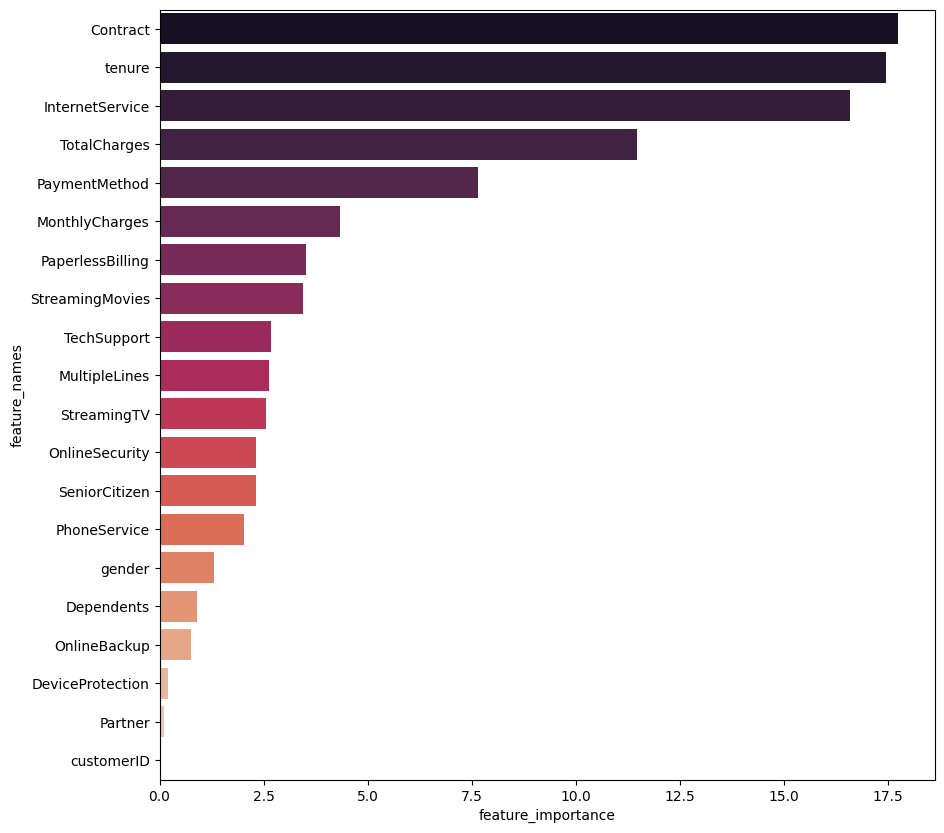

In [52]:
plt.figure(figsize=(10,10))
sns.barplot(x=feature_importance['feature_importance'], y=feature_importance['feature_names'], palette = 'rocket')
plt.show()

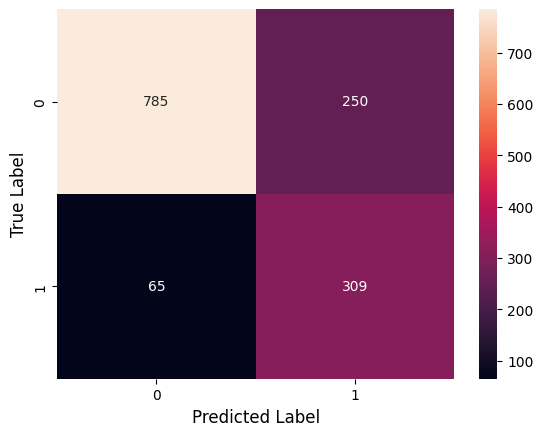

In [53]:
cat_confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cat_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [54]:
print(metrics.classification_report(y_test, y_pred, labels = [0, 1]))


              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1035
           1       0.55      0.83      0.66       374

    accuracy                           0.78      1409
   macro avg       0.74      0.79      0.75      1409
weighted avg       0.83      0.78      0.79      1409



SHAP    

In [55]:
explainercat = shap.TreeExplainer(cat_model)
shap_values_cat_train = explainercat.shap_values(X_train)
shap_values_cat_test = explainercat.shap_values(X_test)


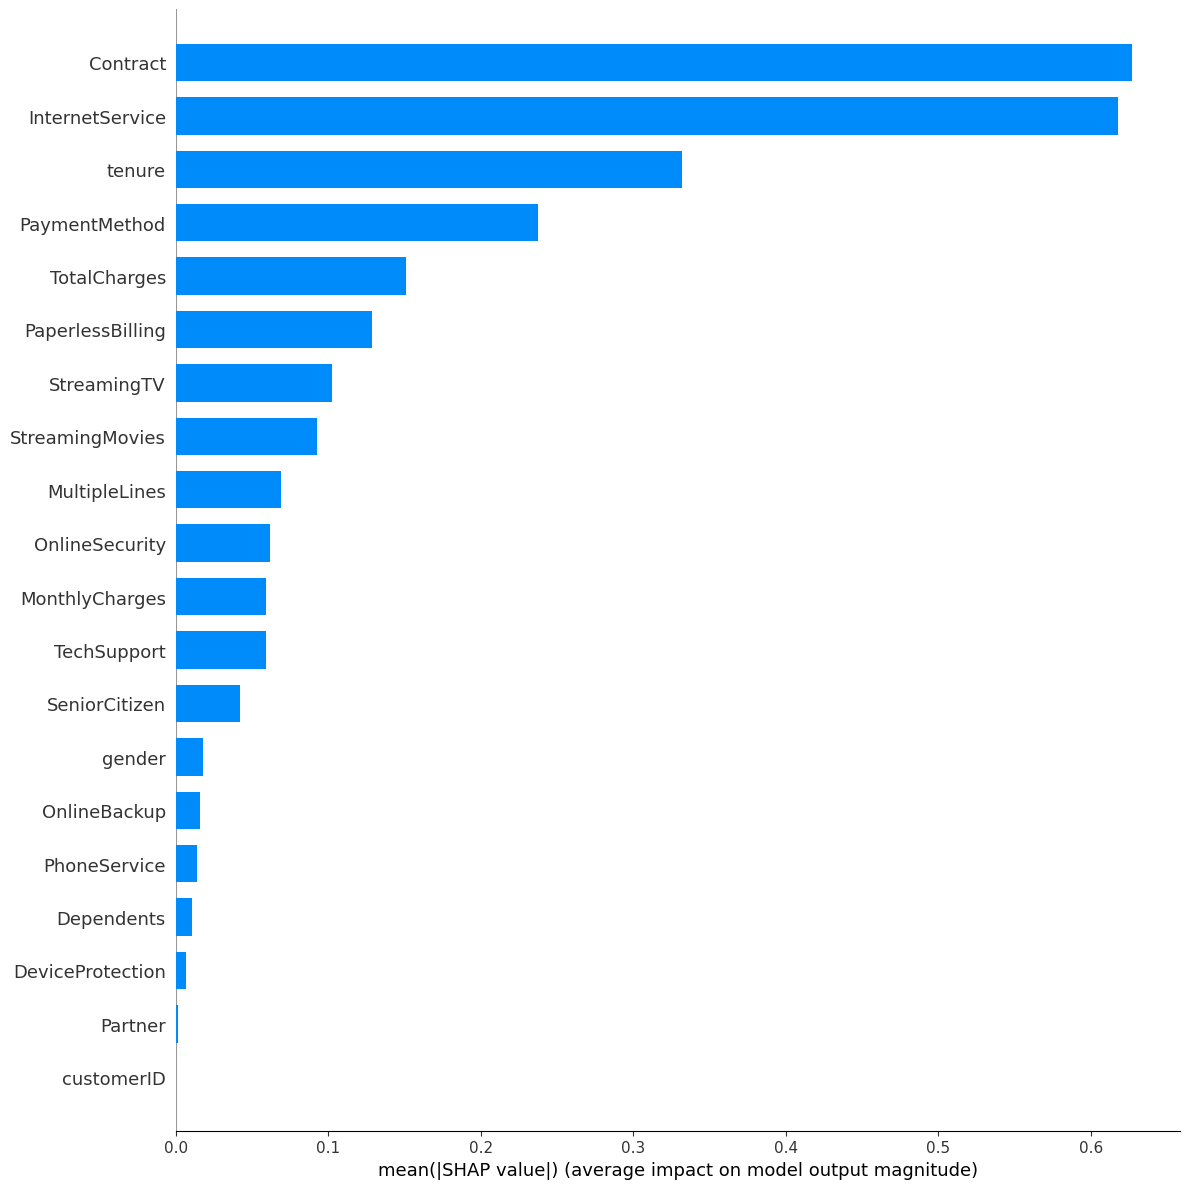

In [56]:
shap.summary_plot(shap_values_cat_train, X_train, plot_type="bar",plot_size=(12,12))

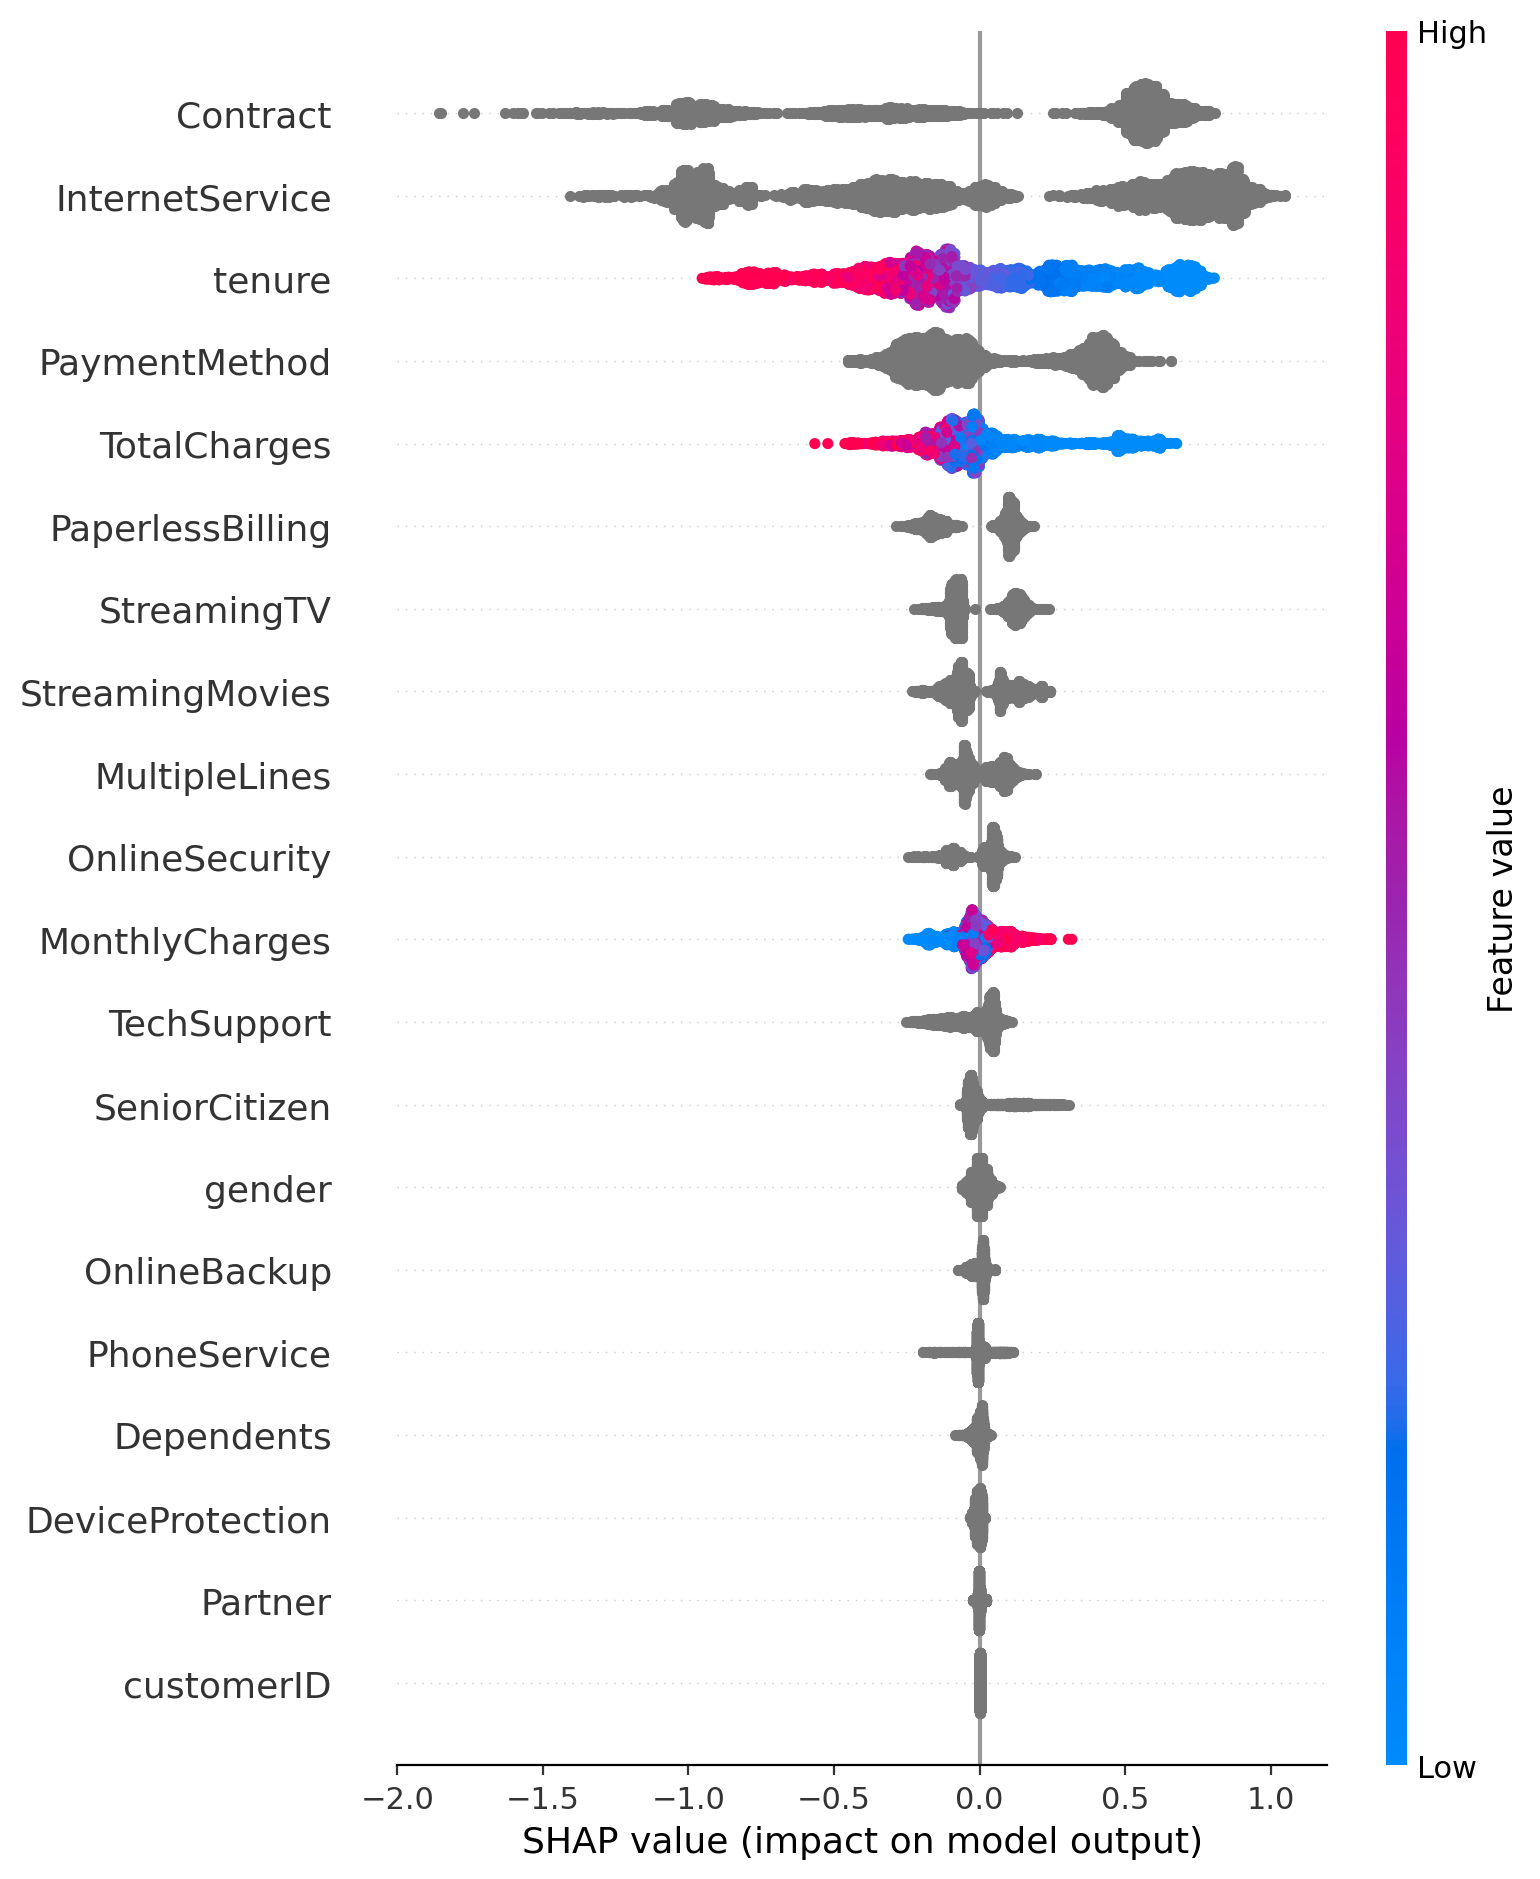

In [57]:
fig = plt.subplots(figsize=(6,6),dpi=200)

ax = shap.summary_plot(shap_values_cat_train, X_train,plot_type="dot")

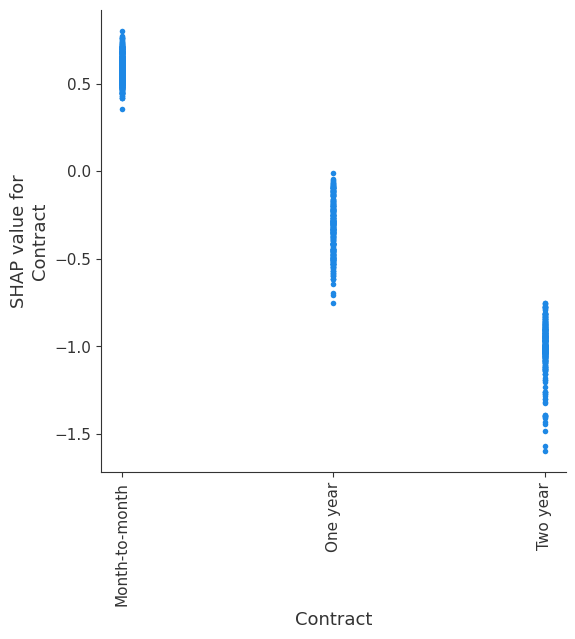

In [58]:
fig, ax= plt.subplots(figsize=(6,6),dpi=100)
shp_plt = shap.dependence_plot("Contract", shap_values_cat_test, X_test,ax=ax,interaction_index=None)

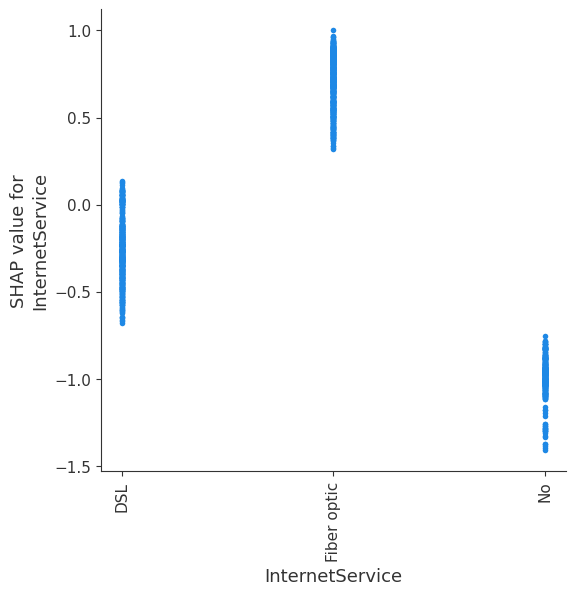

In [59]:
# Internet Service

fig, ax= plt.subplots(figsize=(6,6),dpi=100)

shap.dependence_plot("InternetService", shap_values_cat_test, X_test,ax=ax, interaction_index=None)

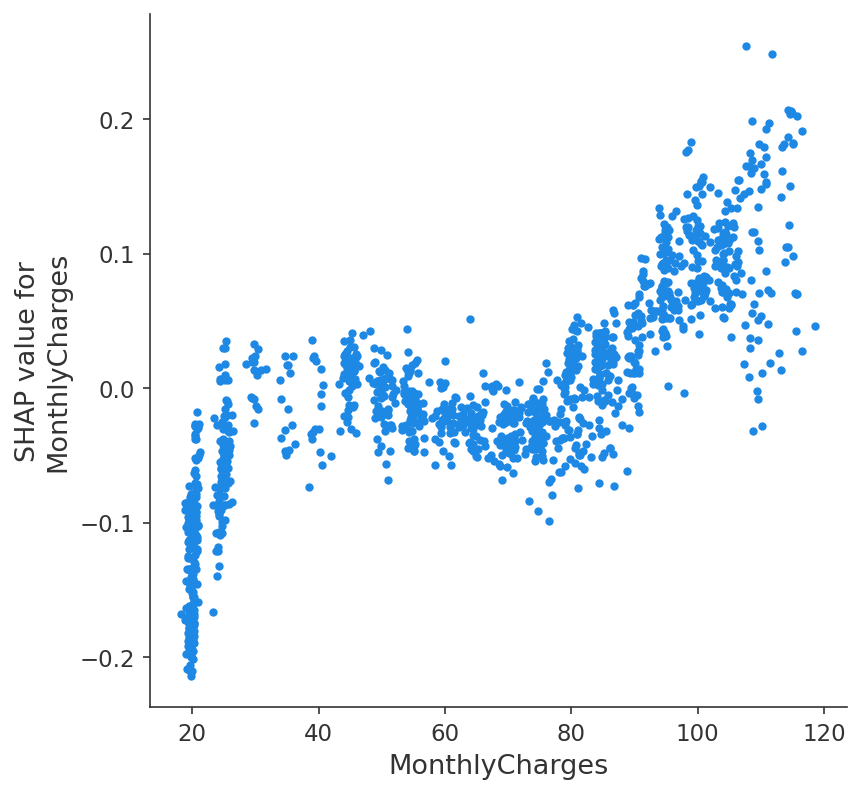

In [60]:
# MonthlyCharges

fig, ax1= plt.subplots(figsize=(6,6),dpi=150)

shp_plt = shap.dependence_plot("MonthlyCharges", shap_values_cat_test,X_test,ax=ax1, interaction_index=None)

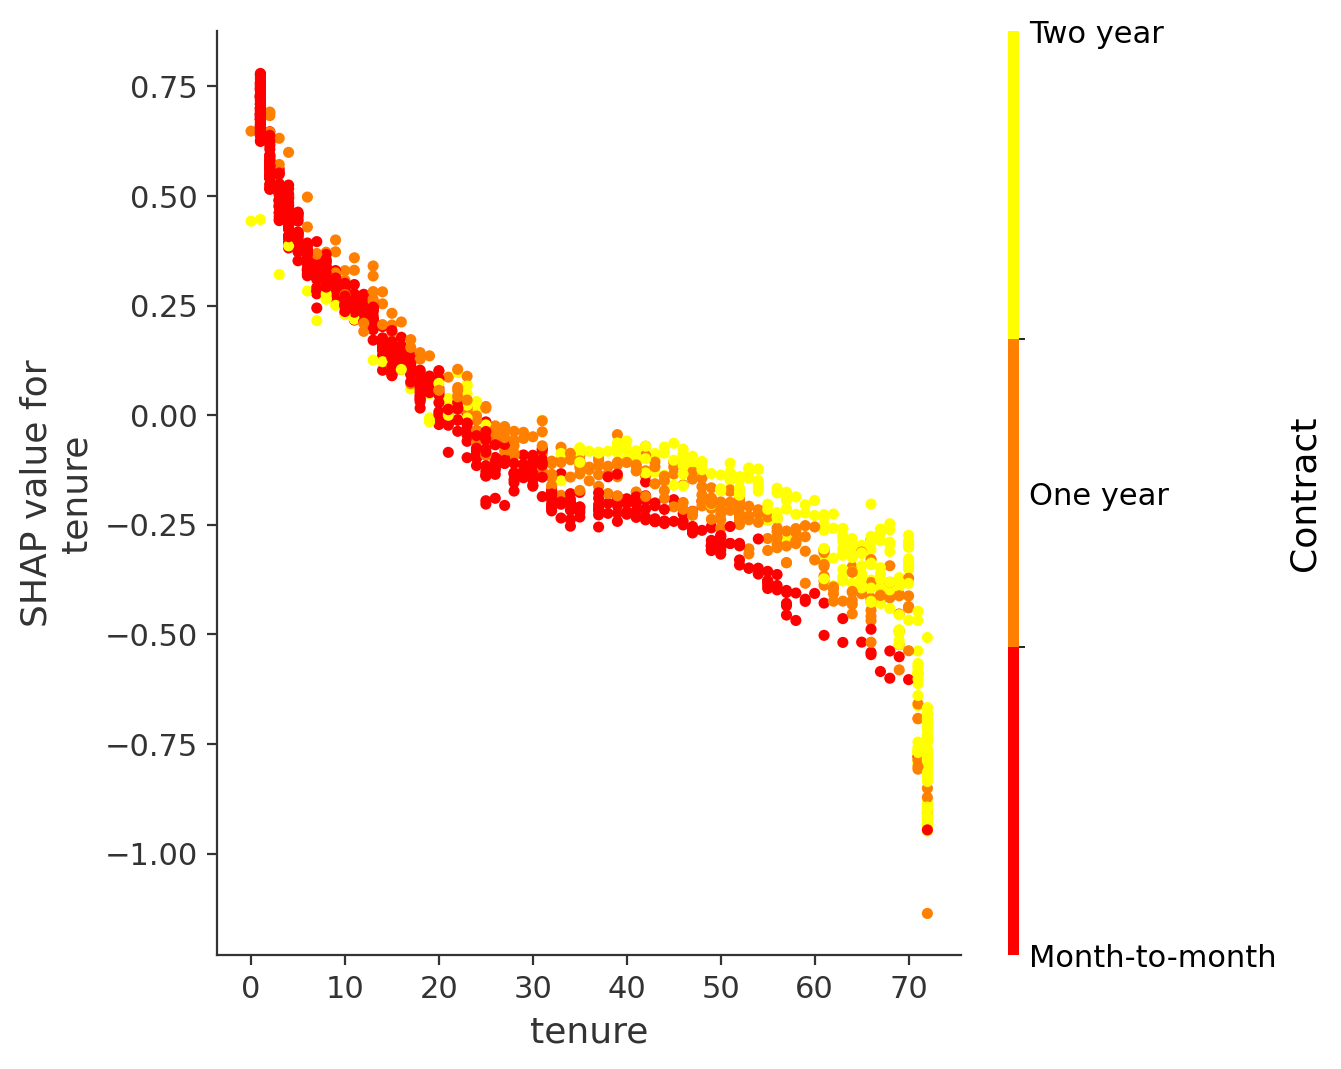

In [61]:
# Tenure - Contract Churn

fig, ax3 = plt.subplots(figsize=(6,6),dpi=200)
shp_plt = shap.dependence_plot("tenure", shap_values_cat_test, X_test, interaction_index="Contract", ax=ax3, cmap=plt.get_cmap('autumn'))

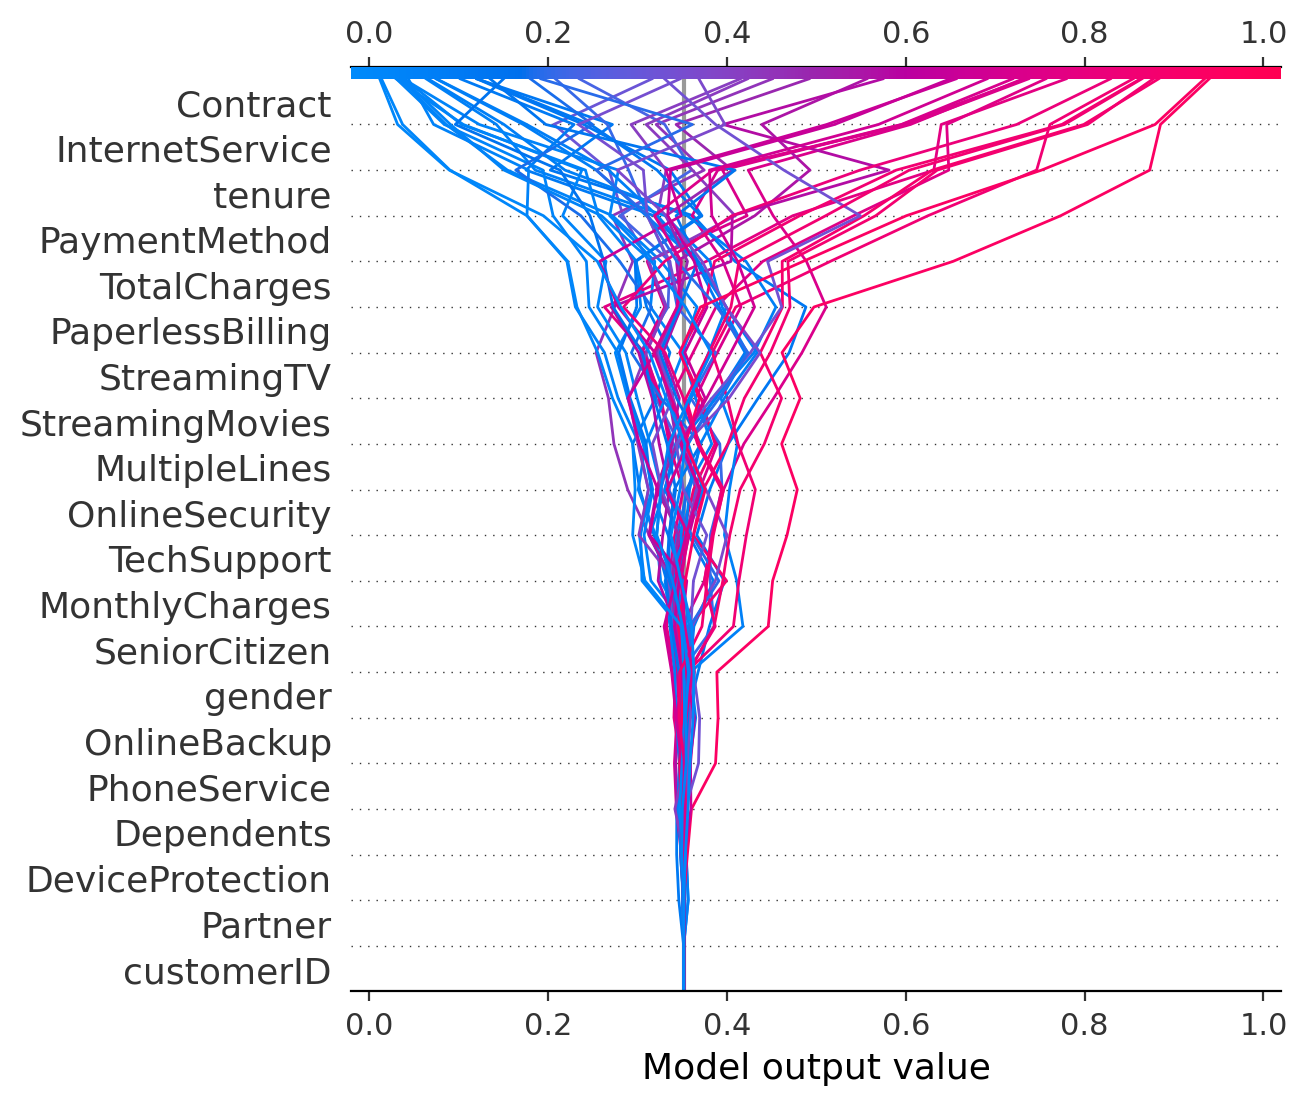

In [62]:
fig = plt.subplots(figsize=(6,6),dpi=200)
ax_1= shap.decision_plot(explainercat.expected_value, shap_values_cat_test[:50], X_test.iloc[:50],auto_size_plot=False, link= "logit")

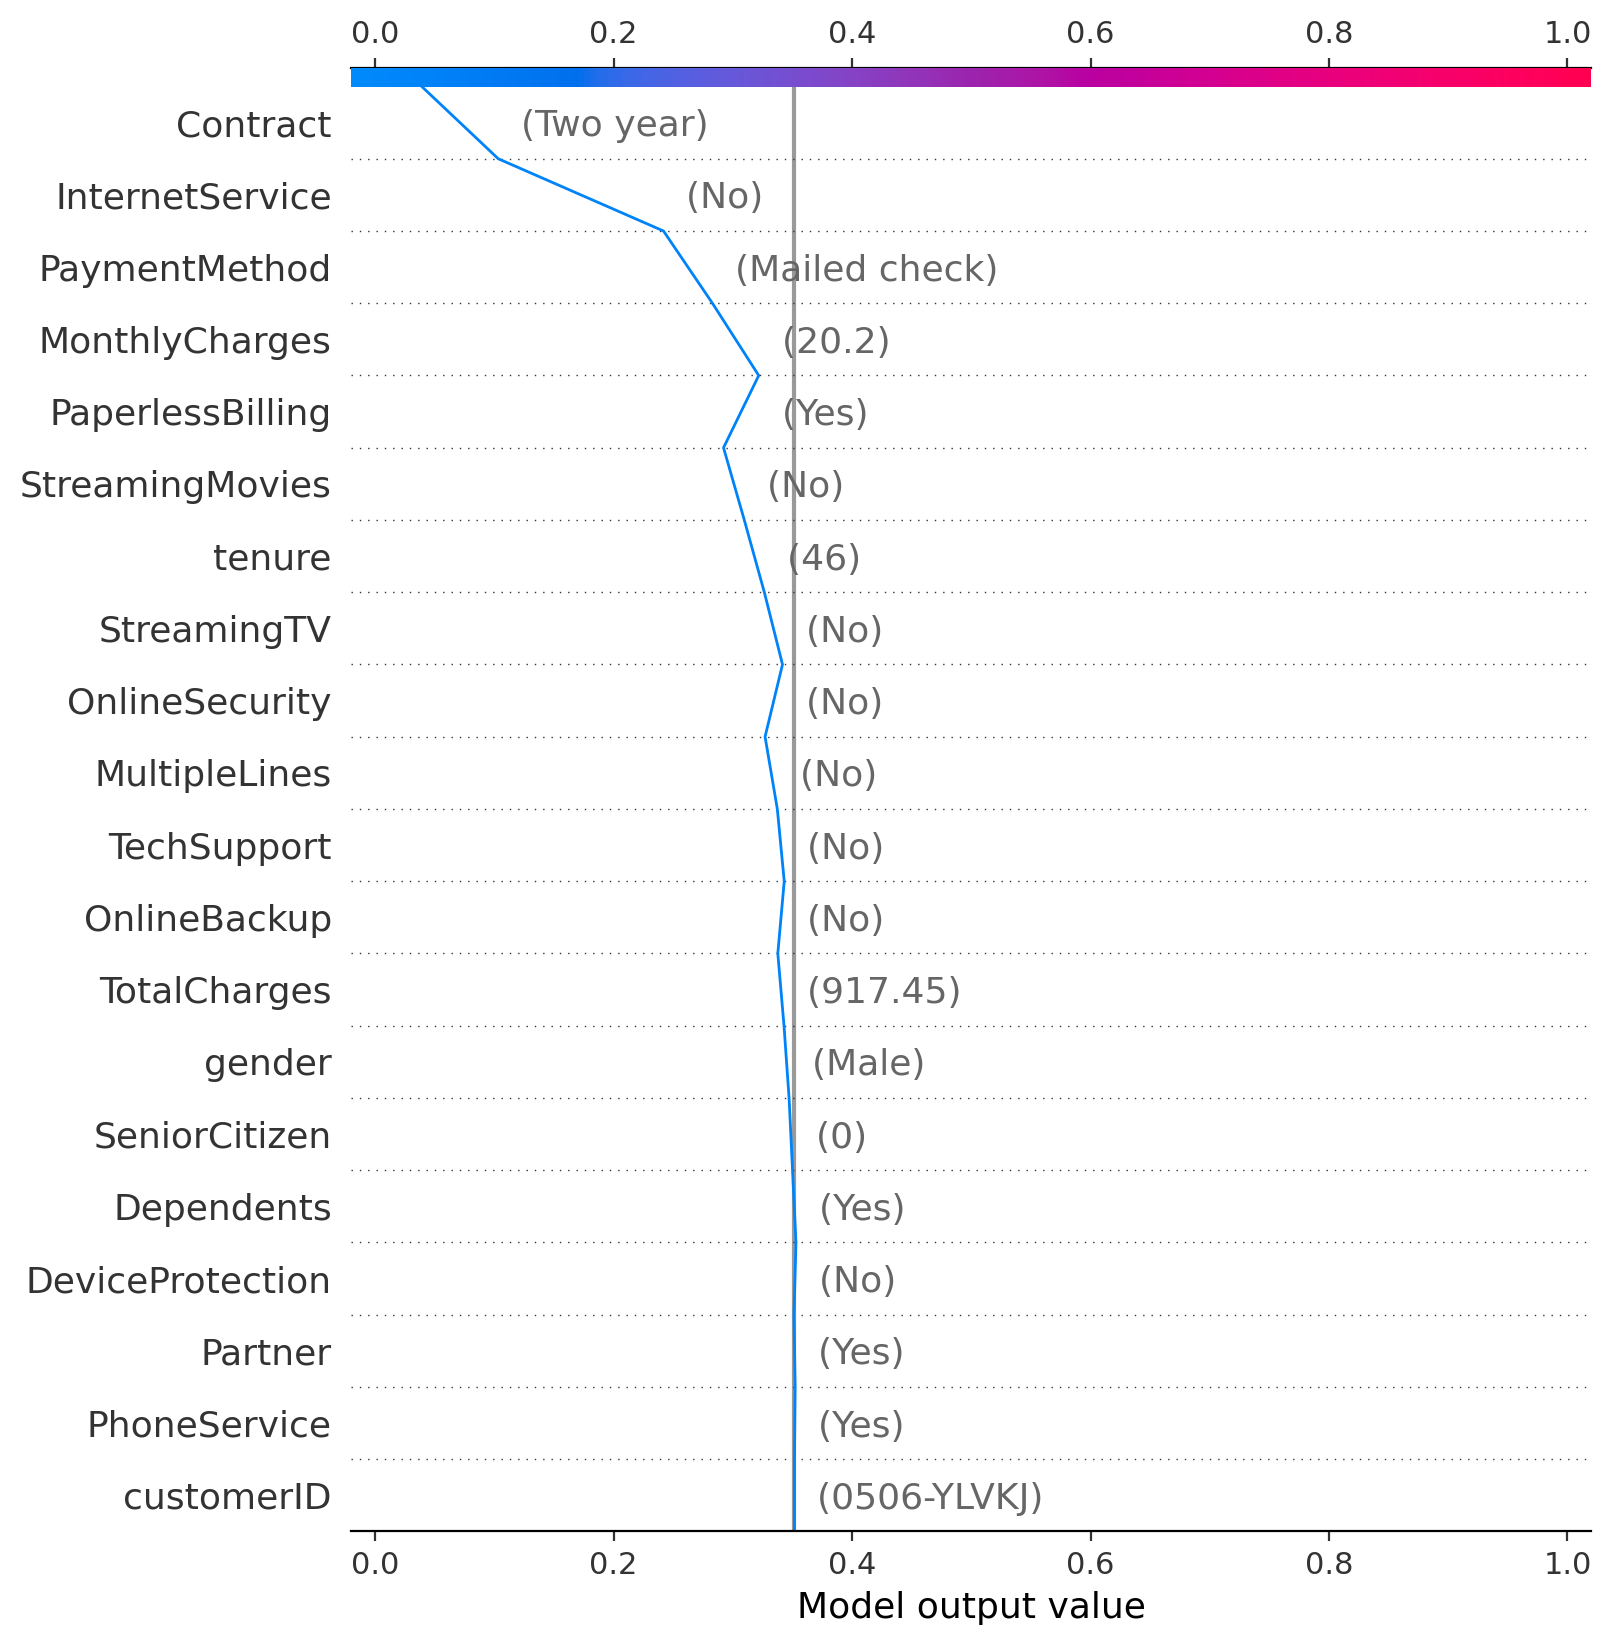

In [63]:
# Customer Specific Cases: Customer 13 and Customer 64

# X_test.iloc[13]

fig = plt.subplots(figsize=(6,6),dpi=200)
ax_2= shap.decision_plot(explainercat.expected_value, shap_values_cat_test[13], X_test.iloc[[13]], link= "logit")

In [64]:
# Let's see our model prediction on the customer 15:

print(f'Customer 13: Actual value for the Customer Churn : {y_test.iloc[13]}')
print(f"Customer 13: CatBoost Model's prediction for the Customer Churn : {y_pred[13]}")

Customer 13: Actual value for the Customer Churn : 0
Customer 13: CatBoost Model's prediction for the Customer Churn : 0


In [65]:
shap_values_cat_test[64]


array([ 0.        ,  0.0029313 , -0.02838635,  0.00186959,  0.00821847,
        0.41645946, -0.00667258,  0.10415765,  0.90678709,  0.0496978 ,
        0.01186123, -0.0132132 ,  0.02986632,  0.11888099,  0.08885696,
        0.57622877,  0.10261974,  0.42340581,  0.15404745,  0.0516863 ])

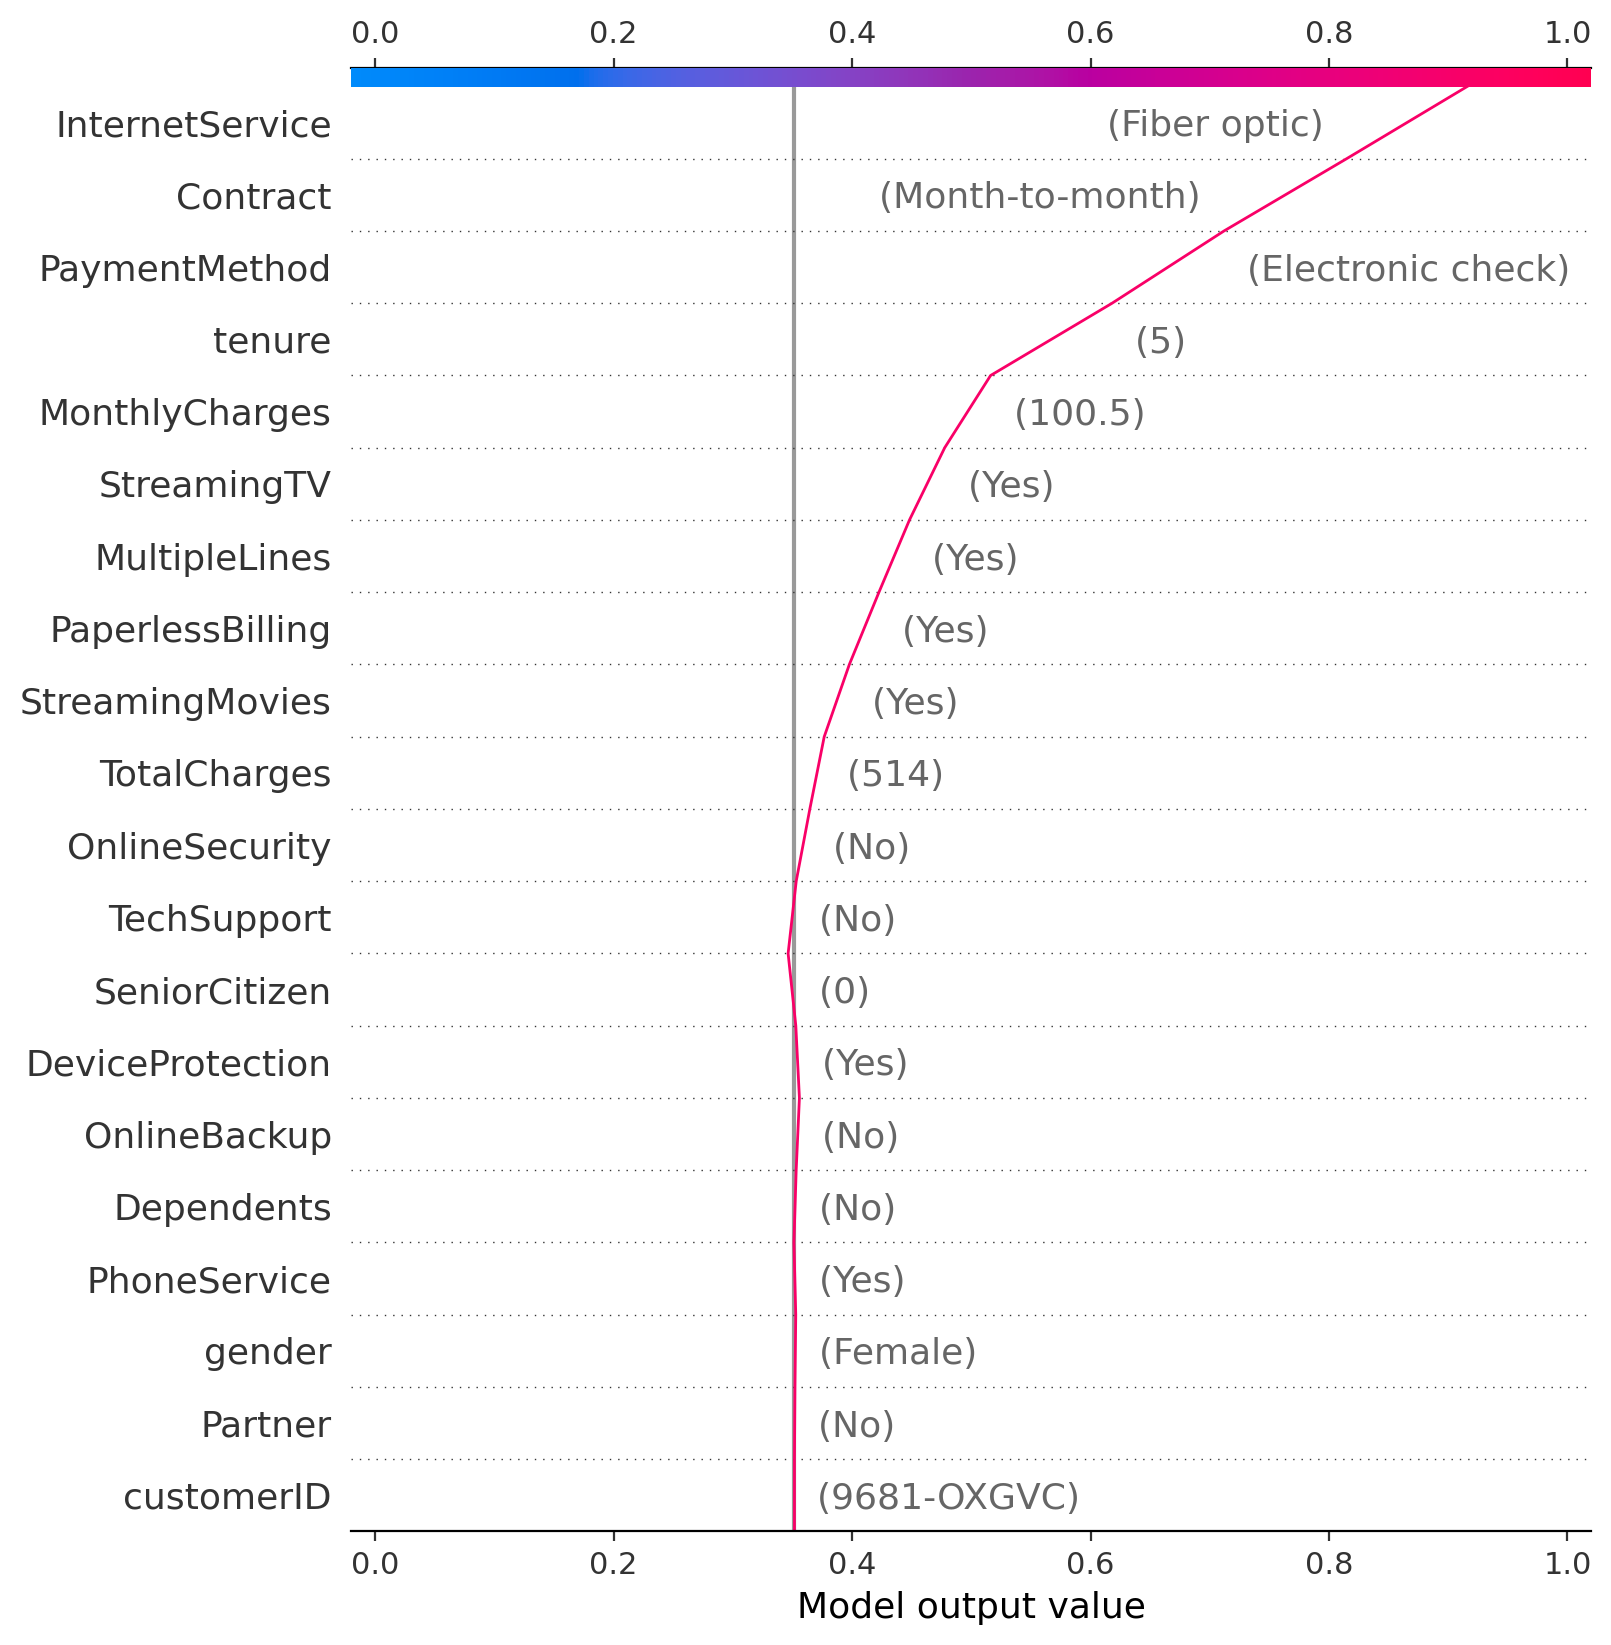

In [66]:
# X_test.iloc[64]

fig = plt.subplots(figsize=(6,6),dpi=200)
ax_2= shap.decision_plot(explainercat.expected_value, shap_values_cat_test[64], X_test.iloc[[64]], link= "logit")


In [67]:
print(f'Customer 64: Actual value for the Customer Churn : {y_test.iloc[64]}')
print(f"Customer 64: CatBoost Model's prediction for the Customer Churn : {y_pred[64]}")

Customer 64: Actual value for the Customer Churn : 1
Customer 64: CatBoost Model's prediction for the Customer Churn : 1


In [68]:
# SHAP FORCE PLOT

shap.initjs()
shap.force_plot(explainercat.expected_value, shap_values_cat_test[:75], X_test.iloc[:75],link= "logit")

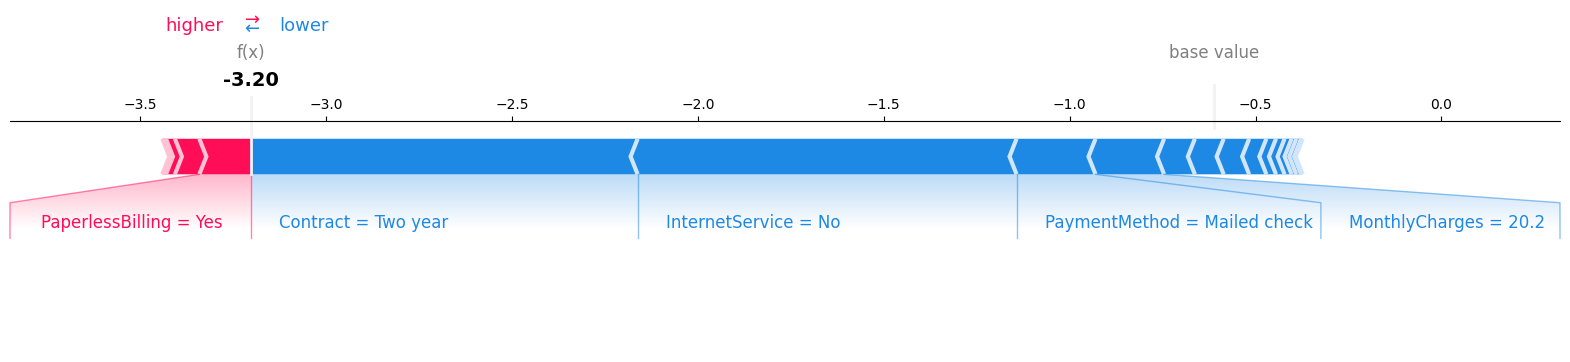

In [69]:
shap.force_plot(
    explainercat.expected_value, 
    shap_values_cat_test[13], 
    X_test.iloc[[13]],
    matplotlib=True
)

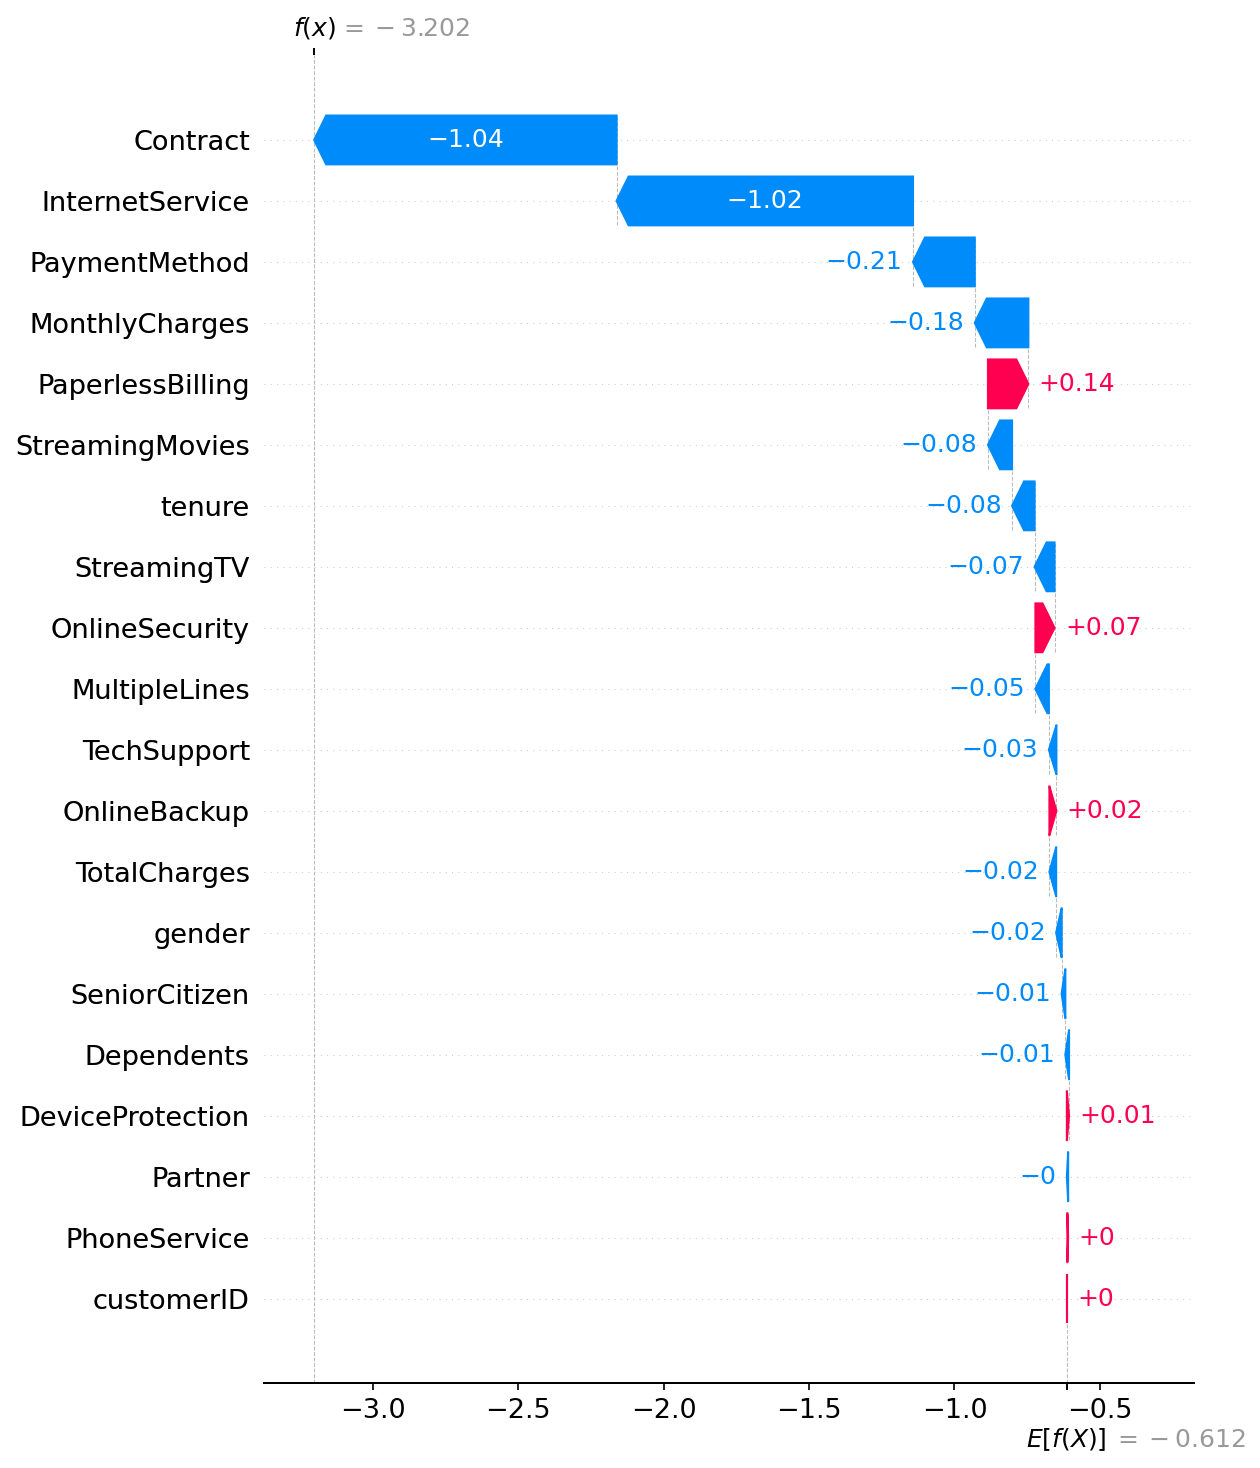

In [70]:
## Waterfall customer 13

fig = plt.subplots(figsize=(6,6),dpi=150)
ax_3= shap.plots._waterfall.waterfall_legacy(explainercat.expected_value, shap_values_cat_test[13], feature_names = X_test.columns,max_display = 20)

XGBOOST

In [71]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

df['MultipleLines'] = df['MultipleLines'].replace('No phone service','No')
columns_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for column in columns_to_replace:
    df[column] = df[column].replace('No internet service', 'No')
    
# Changing categorical variables to numeric:
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})

/tmp/ipykernel_113508/3738006141.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)
/tmp/ipykernel_113508/3738006141.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1

In [72]:
# OrdinalEncoder
encoder = OrdinalEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

X = df.drop('Churn', axis=1).copy()
y = df['Churn'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode categorical columns in Train data
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])

# Encode categorical columns in test data (no fit, only transform)
X_test_encoded = encoder.transform(X_test[categorical_columns])

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=categorical_columns)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=categorical_columns)

xgb = XGBClassifier(random_state=0,scale_pos_weight=3)

xgb.fit(X_train_encoded_df, y_train)
y_pred = xgb.predict(X_test_encoded_df)

accuracy, recall, roc_auc, precision = [round(metric(y_test, y_pred), 4) for metric in [accuracy_score, recall_score, roc_auc_score, precision_score]]

model_names = ['XGBoost_adjusted_weight_3']
result_df3 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df3

Accuracy  Recall  Roc_Auc  Precision
XGBoost_adjusted_weight_3    0.7346  0.7239   0.7311     0.4991

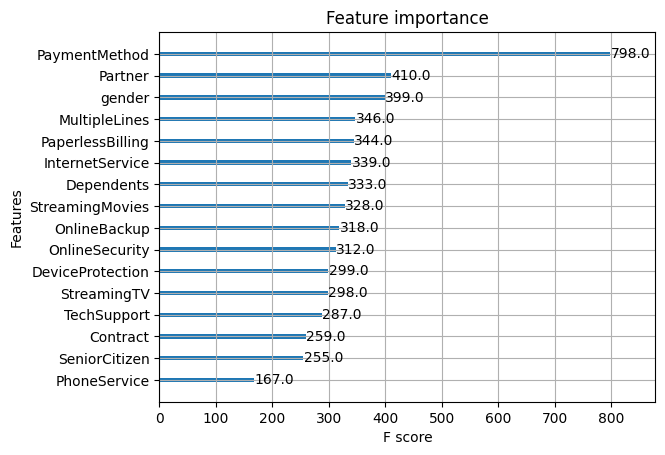

In [73]:
plot_importance(xgb)
plt.show()

LIME

In [74]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_encoded_df.values, feature_names=X_train_encoded_df.columns.values.tolist(),
                                                  class_names=['Churn'], verbose=True, mode='classification')

# Choose the jth instance and use it to predict the results for that selection
j = 13
exp = explainer.explain_instance(X_train_encoded_df.values[j], xgb.predict_proba, num_features=5)

Intercept 0.2549167914396944
Prediction_local [0.2392001]
Right: 0.021771623


In [75]:
exp.show_in_notebook(show_table=True)


In [76]:
# This script should be run in the Python 2 environment
import joblib
from catboost import CatBoostClassifier

# Load the model
model_path = "cat_model.cbm"
model = CatBoostClassifier()
model.load_model(model_path)

# Save the model in a way compatible with Python 3
joblib.dump(model, "cat_model_py3.pkl")


['/home/karuturividyasagar/platform/learning_rough/deeplearning/churn_prediction_project/cat_model_py3.pkl']